In [1]:
import sys
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from scipy.stats import ttest_1samp
%matplotlib inline

if '..' not in sys.path:
    sys.path.append('..')
import make_bayes_submission
from make_submission import sigmoid, logit

In [21]:
train_flat = pd.read_csv('../../_data/train_flat.csv', index_col=0)
train_flat[:3]

,agriculture,artisinal_mine,bare_ground,blooming,blow_down,clear,cloudy,conventional_mine,cultivation,habitation,haze,partly_cloudy,primary,road,selective_logging,slash_burn,water
image_name,,,,,,,,,,,,,,,,,
train_0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
train_1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1
train_2,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0


In [46]:
valid_pred = pd.read_hdf('../../_data/20170720-005737-b6-albu-0.93359-eval.h5').loc[train_flat.index]
valid_pred = valid_pred.loc[train_flat.index]
valid_pred[:3]

,agriculture,artisinal_mine,bare_ground,blooming,blow_down,clear,cloudy,conventional_mine,cultivation,habitation,haze,partly_cloudy,primary,road,selective_logging,slash_burn,water
image_name,,,,,,,,,,,,,,,,,
train_0,0.003930,0.004211,0.002263,0.001794,0.002070,0.591027,0.006670,0.001795,0.002431,0.002176,0.683836,0.002359,0.997151,0.002328,0.002150,0.001753,0.003885
train_1,0.818843,0.005387,0.014422,0.001886,0.001836,0.997251,0.003316,0.002329,0.455737,0.028945,0.002248,0.002191,0.997231,0.500173,0.004191,0.016922,0.818798
train_2,0.003150,0.003586,0.002302,0.001734,0.001651,0.997664,0.004536,0.001653,0.001856,0.002268,0.001843,0.002075,0.997267,0.002243,0.002193,0.002039,0.002790


In [35]:
def f2_score(y_true, y_pred, eps=1e-7) -> float:
    # same as fbeta_score(y_true, y_pred, beta=2, average='samples')
    # but faster
    if isinstance(y_true, pd.DataFrame):
        y_true = y_true.as_matrix()
    if isinstance(y_pred, pd.DataFrame):
        y_pred = y_pred.as_matrix()
    tp = (y_true * y_pred).sum(axis=1)
    r = tp / y_true.sum(axis=1)
    p = tp / (y_pred.sum(axis=1) + eps)
    beta2 = 4
    f2 = (1 + beta2) * p * r / (beta2 * p + r + eps)
    return f2.mean()

In [52]:
threshold = 0.2
original_score = f2_score(train_flat, valid_pred > threshold)
original_score

0.93359010922228391

In [40]:
for th in np.linspace(0.15, 0.35, 100):
    score = f2_score(train_flat, valid_pred > th)
    if score > original_score:
        print('{:.4f} {:.7f}'.format(th, score - original_score))

best th 0.281, valid delta +0.000344
best th 0.289, valid delta +0.000473
best th 0.318, valid delta +0.000399
best th 0.293, valid delta -0.000855
best th 0.289, valid delta -0.000245
best th 0.328, valid delta -0.000125
best th 0.318, valid delta -0.000073
best th 0.289, valid delta +0.000283
best th 0.269, valid delta -0.000257
best th 0.289, valid delta -0.000085
Mean delta -0.00001, mean threshold 0.296
T-test: Ttest_1sampResult(statistic=-0.10965614595531323, pvalue=0.91508821866584966)


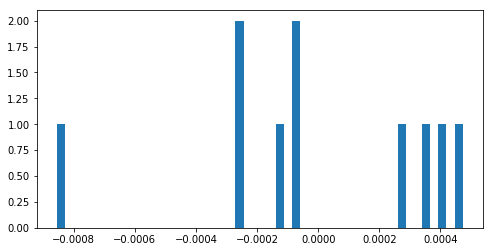

In [51]:
deltas = []
thresholds = []
for train_ids, valid_ids in KFold(n_splits=10, shuffle=True).split(valid_pred.index):
    best_score = 0
    best_th = 0.2
    for th in np.linspace(0.15, 0.35, 100):
        score = f2_score(train_flat.iloc[train_ids], valid_pred.iloc[train_ids] > th)
        if score > best_score:
            best_score = score
            best_th = th
    delta = (f2_score(train_flat.iloc[valid_ids], valid_pred.iloc[valid_ids] > best_th) -
             f2_score(train_flat.iloc[valid_ids], valid_pred.iloc[valid_ids] > 0.2))
    deltas.append(delta)
    thresholds.append(best_th)
    print('best th {:.3f}, valid delta {:+.6f}'.format(best_th, delta))
    # print('{:+.5f}'.format(delta))
plt.figure(figsize=(8, 4))
plt.hist(deltas, bins=50);
print('Mean delta {:+.5f}, mean threshold {:.3f}'.format(np.mean(deltas), np.mean(thresholds)))
print('T-test: {}'.format(ttest_1samp(deltas, 0)))

Mean delta +0.000132
T-test: Ttest_1sampResult(statistic=19.028434315192772, pvalue=3.9469942484758796e-69)


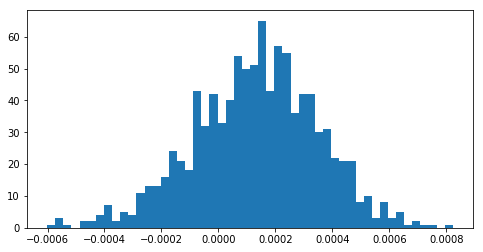

In [124]:
deltas = []
for _ in range(100):
    for train_ids, valid_ids in KFold(n_splits=10, shuffle=True).split(valid_pred.index):
        hack = valid_pred.iloc[valid_ids].copy()
        hack[hack['cloudy'] > .6] *= .6
        delta = (f2_score(train_flat.iloc[valid_ids], hack > threshold) -
                 f2_score(train_flat.iloc[valid_ids], valid_pred.iloc[valid_ids] > threshold))
        deltas.append(delta)
        # print('{:+.5f}'.format(delta))
plt.figure(figsize=(8, 4))
plt.hist(deltas, bins=50);
print('Mean delta {:+.6f}'.format(np.mean(deltas)))
print('T-test: {}'.format(ttest_1samp(deltas, 0)))

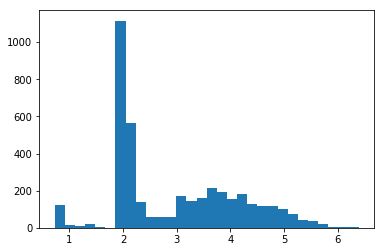

In [28]:
plt.hist(hack.as_matrix().sum(axis=1), bins=30);

In [53]:
bayes_valid = make_bayes_submission.get_df_prediction(valid_pred)

In [54]:
new_score = f2_score(train_flat, bayes_valid)
print('{:.6f}, {:.6f}'.format(new_score, new_score - original_score))

0.933658, 0.000068


In [55]:
for alpha in [0.05, 0.1, 0.15]:
    new_score = f2_score(
        train_flat,
        make_bayes_submission.get_df_prediction(valid_pred * (1 + alpha)))
    print('alpha={:.2f}, score={:.6f}, delta={:.6f}'.format(alpha, new_score, new_score - original_score))

alpha=0.05, score=0.933632, delta=0.000042
alpha=0.10, score=0.933638, delta=0.000048
alpha=0.15, score=0.933538, delta=-0.000052


In [35]:
for delta in [-0.03, -0.01, 0.01, 0.03]:
    new_score = f2_score(
        train_flat,
        make_bayes_submission.get_df_prediction(sigmoid(logit(valid_pred) + delta)))
    print('delta={:.2f}, score={:.6f}, delta={:.6f}'.format(delta, new_score, new_score - original_score))

delta=-0.05, score=0.933657, delta=0.000066
delta=-0.10, score=0.933619, delta=0.000027
delta=0.05, score=0.933533, delta=-0.000058


In [45]:
new_score = f2_score(train_flat, make_bayes_submission.get_df_prediction(valid_pred, min_p=0.03, max_p=0.5))
print('{:.6f}, {:.6f}'.format(new_score, new_score - original_score))

0.933270, 0.000061


Mean delta +0.000057
T-test: Ttest_1sampResult(statistic=6.1884754633871157, pvalue=8.8523569279878356e-10)


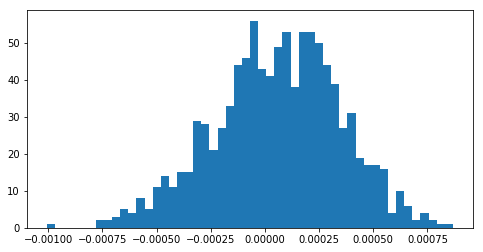

In [32]:
deltas = []
for _ in range(100):
    for train_ids, valid_ids in KFold(n_splits=10, shuffle=True).split(valid_pred.index):
        bayes = make_bayes_submission.get_df_prediction(valid_pred.iloc[valid_ids])
        delta = (f2_score(train_flat.iloc[valid_ids], bayes) -
                 f2_score(train_flat.iloc[valid_ids], valid_pred.iloc[valid_ids] > threshold))
        deltas.append(delta)
plt.figure(figsize=(8, 4))
plt.hist(deltas, bins=50);
print('Mean delta {:+.6f}'.format(np.mean(deltas)))
print('T-test: {}'.format(ttest_1samp(deltas, 0)))

Mean delta +0.000112
T-test: Ttest_1sampResult(statistic=3.3712499186743745, pvalue=0.0010683301814363732)


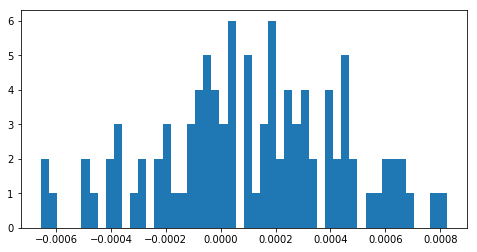

In [34]:
deltas = []
for _ in range(10):
    for train_ids, valid_ids in KFold(n_splits=10, shuffle=True).split(valid_pred.index):
        hack = valid_pred.iloc[valid_ids].copy()
        hack[hack['cloudy'] > .7] *= .7
        bayes = make_bayes_submission.get_df_prediction(hack)
        delta = (f2_score(train_flat.iloc[valid_ids], bayes) -
                 f2_score(train_flat.iloc[valid_ids], valid_pred.iloc[valid_ids] > threshold))
        deltas.append(delta)
plt.figure(figsize=(8, 4))
plt.hist(deltas, bins=50);
print('Mean delta {:+.6f}'.format(np.mean(deltas)))
print('T-test: {}'.format(ttest_1samp(deltas, 0)))

In [6]:
bayes_shifted = make_bayes_submission.get_df_prediction(sigmoid(logit(valid_pred) + 0.1))

Mean delta +0.000154
T-test: Ttest_1sampResult(statistic=28.651988829842661, pvalue=2.8791999077179275e-132)


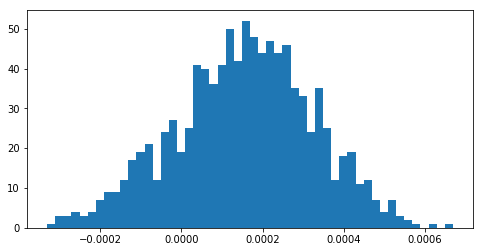

In [10]:
deltas = []
for _ in range(100):
    for train_ids, valid_ids in KFold(n_splits=10, shuffle=True).split(valid_pred.index):
        delta = (f2_score(train_flat.iloc[valid_ids], bayes_shifted.iloc[valid_ids]) -
                 f2_score(train_flat.iloc[valid_ids], valid_pred.iloc[valid_ids] > threshold))
        deltas.append(delta)
plt.figure(figsize=(8, 4))
plt.hist(deltas, bins=50);
print('Mean delta {:+.6f}'.format(np.mean(deltas)))
print('T-test: {}'.format(ttest_1samp(deltas, 0)))

In [119]:
hack = valid_pred.copy()
for cls in hack.columns:
    if cls != 'cloudy':
        hack[cls][hack['cloudy'] > .8] *= .8
bayes_shifted_hack = make_bayes_submission.get_df_prediction(hack)        

Mean delta +0.000139
T-test: Ttest_1sampResult(statistic=17.250611410018571, pvalue=1.4431135265726424e-58)


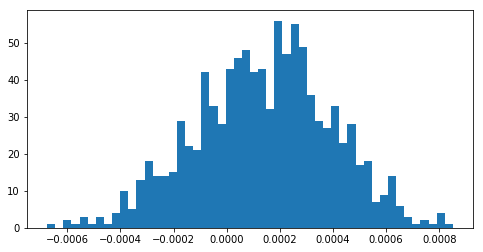

In [120]:
deltas = []
for _ in range(100):
    for train_ids, valid_ids in KFold(n_splits=10, shuffle=True).split(valid_pred.index):
        delta = (f2_score(train_flat.iloc[valid_ids], bayes_shifted_hack.iloc[valid_ids]) -
                 f2_score(train_flat.iloc[valid_ids], valid_pred.iloc[valid_ids] > threshold))
        deltas.append(delta)
plt.figure(figsize=(8, 4))
plt.hist(deltas, bins=50);
print('Mean delta {:+.6f}'.format(np.mean(deltas)))
print('T-test: {}'.format(ttest_1samp(deltas, 0)))

In [101]:
test_pred = pd.read_hdf('../../_data/20170720-005737-b6-albu-0.93359-test.h5')
test_pred[:3]

,agriculture,artisinal_mine,bare_ground,blooming,blow_down,clear,cloudy,conventional_mine,cultivation,habitation,haze,partly_cloudy,primary,road,selective_logging,slash_burn,water
image_name,,,,,,,,,,,,,,,,,
test_0,0.004249,0.004020,0.002376,0.024152,0.001545,0.996132,0.004403,0.001392,0.002579,0.002318,0.006539,0.002092,0.997258,0.002250,0.002649,0.001739,0.003148
test_1,0.017300,0.004036,0.002536,0.018544,0.029022,0.997545,0.004417,0.001398,0.011012,0.002550,0.001860,0.002161,0.997224,0.002481,0.009337,0.001798,0.003468
test_2,0.009258,0.004022,0.002338,0.001726,0.001536,0.003710,0.004437,0.001400,0.003209,0.002218,0.001828,0.996449,0.997256,0.003019,0.002166,0.001774,0.013507


In [57]:
bayes_test = make_bayes_submission.get_df_prediction(test_pred)        

In [60]:
bayes_test[:3]

,agriculture,artisinal_mine,bare_ground,blooming,blow_down,clear,cloudy,conventional_mine,cultivation,habitation,haze,partly_cloudy,primary,road,selective_logging,slash_burn,water
image_name,,,,,,,,,,,,,,,,,
test_0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
test_1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
test_2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


In [121]:
hack_test = valid_pred.copy()
for cls in hack_test.columns:
    if cls != 'cloudy':
        hack_test[cls][hack_test['cloudy'] > .8] *= .8
hack_test = make_bayes_submission.get_df_prediction(hack_test)

In [122]:
out_df = pd.DataFrame([
    {'tags': ' '.join(c for c in hack_test.columns if row[c])
     } for image_name, row in hack_test.iterrows()],
    index=hack_test.index)

In [123]:
out_df[:10]

,tags
image_name,
train_0,clear haze primary
train_1,agriculture clear cultivation primary road water
train_2,clear primary
train_3,clear primary
train_4,agriculture clear cultivation habitation prima...
train_5,haze primary road water
train_6,agriculture clear cultivation primary water
train_7,cloudy haze primary
train_8,agriculture clear cultivation primary


In [125]:
out_df.to_csv('../../20170720-005737-b6-albu-0.93359-weather0808-bayes-test.csv', index_label='image_name')

In [126]:
! head ../../20170720-005737-b6-albu-0.93359-weather0808-bayes-test.csv

image_name,tags
train_0,clear haze primary
train_1,agriculture clear cultivation primary road water
train_2,clear primary
train_3,clear primary
train_4,agriculture clear cultivation habitation primary road water
train_5,haze primary road water
train_6,agriculture clear cultivation primary water
train_7,cloudy haze primary
train_8,agriculture clear cultivation primary


In [68]:
submit = pd.read_csv('/Users/kostia/Downloads/20170720-005737-b6-albu-0.93359_weather_hack0406.csv', index_col=0)
submit[:3]

,tags
image_name,
test_0,clear primary
test_1,clear primary
test_2,partly_cloudy primary


In [99]:
out_df[(out_df != submit.loc[out_df.index])['tags']][:10]

,tags
image_name,
test_99,clear cloudy water
test_171,clear cloudy water
test_208,clear cloudy water
test_265,agriculture cloudy partly_cloudy primary
test_316,cloudy partly_cloudy primary road water
test_436,clear cloudy water
test_476,cloudy partly_cloudy primary
test_558,agriculture cloudy partly_cloudy primary water
test_604,clear cloudy water


In [100]:
submit[(out_df != submit.loc[out_df.index])['tags']][:10]

,tags
image_name,
test_99,cloudy
test_171,clear cloudy
test_208,clear water
test_265,agriculture partly_cloudy primary
test_316,cloudy partly_cloudy primary road
test_436,cloudy
test_476,cloudy
test_558,cloudy partly_cloudy primary
test_604,cloudy


In [80]:
len(out_df)

61191

In [82]:
1 - 59790 / 61191

0.022895523851546806

In [85]:
(out_df != test_pred).sum()

ValueError: Can only compare identically-labeled DataFrame objects